# Teched 2022 DA180 Workshop - Ex6 Build a classification model on multi-model data

In this exercise, we want to apply SAP HANA Cloud multi-model processing techniques to prepare and assemble geo-located information about fuel stations in Germany, and make use of Machine Learning classification techniques from the [Predictive Analysis Library (PAL)](https://help.sap.com/docs/HANA_CLOUD_DATABASE/319d36de4fd64ac3afbf91b1fb3ce8de/c9eeed704f3f4ec39441434db8a874ad.html?locale=en-US) to model price-class categories for the fuels stations and deduct influence of station attributes incl. spatial attributes and their impact explaining the price-classes.

This exercise builds on top of exercise 5, hence the exercise 5 tasks need to be completed before starting with this section.

The __objective and goals__ for this exercise is

- in ex 6.1 to build a fuel station price-class label variable based on average e5 fuel-price levels and build station master data- and price-indicator attributes dataframes
- in ex 6.2 to an additional station attribute dataframe with multiple geo-location derived attributes
- in ex 6.3 to build a station price-class classification model, review feature influence (esp. of spatial features) on the price-class labels.

As an extra and optional exercise, the [add-on section]()  describes how to evaluate, store and debrief the classifier model in more detail. Furthermore an add-on exercise describes how to download German-highway network data and calculate the spatial distance between stations and the next highway.


# Preparation steps in your Python Jupyter Notebook

## Import the required python packages

In [129]:
import hana_ml
print(hana_ml.__version__)
from hana_ml import dataframe
from hana_ml.dataframe import create_dataframe_from_pandas, create_dataframe_from_shapefile
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast
from hana_ml.algorithms.pal import metrics
from hdbcli import dbapi
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon


2.14.22101400


## Connect to SAP HANA Cloud database

In [ ]:
host = '[YourHostName]'
port = 443
user = '[YourUser]'
passwd = '[YourUserPassword]'

In [3]:
#conn = dataframe.ConnectionContext(url, port, user, pwd)
conn= dataframe.ConnectionContext(address=host, port=port, user=user, password=passwd,
                               encrypt='true' ,sslValidateCertificate='false')

In [130]:
#conn = dataframe.ConnectionContext( address="<machine>", port=<SQL-port>,  user="<HANA-user>", password="<password>")
hc_url = '859c0f95-60f9-4540-aa81-581a8e452c6f.hna1.canary-eu10.hanacloud.ondemand.com'
conn = dataframe.ConnectionContext( address=hc_url, port=443, user="TECHED_USER_999", password='TechEd22Welcome' )
conn.hana_version()

'4.00.000.00.1663064250 (fa/CE2022.30)'

# Ex 6.1 - Prepare and explore fuel station classification data

__Step 1 - Create the classification label-column__  
Using an advanced SQL statement, we define a HANA dataframe with the STATION_CLASS target column, deriving a station's fuel price class from it's average daily-average e5 price.

In [131]:
# Creating a station price class type label "STATION_CLASS", derived from daily average e5-price
stations_class=conn.sql(
"""
SELECT "station_uuid", E5_AVG, BINNING(VALUE => E5_AVG, BIN_COUNT => 10) OVER () AS STATION_CLASS 
  FROM ( SELECT  "station_uuid",  avg("e5") AS E5_AVG 
         FROM (  SELECT "station_uuid", "date", 
	                      EXTRACT(DAY FROM "date")||'-'||EXTRACT(MONTH FROM "date")||'-'||EXTRACT(YEAR FROM "date") AS "DAY", 
	                      HOUR("date") as HOUR, 
                          "e5", "e5change"
                 FROM  RAW_DATA.GAS_PRICES_ANALYSIS 
                 WHERE  "e5" > 1.3 AND "e5" < 2.8)
         GROUP BY "station_uuid" 
         HAVING COUNT("e5")>20);  
"""
)
stations_class.collect()

,station_uuid,E5_AVG,STATION_CLASS
0,00006210-0037-4444-8888-acdc00006210,1.948780,4
1,00016899-3247-4444-8888-acdc00000007,1.992414,5
2,00041414-208c-4444-8888-acdc00000414,2.016500,5
3,00041450-0002-4444-8888-acdc00000002,1.931636,4
4,00047369-0001-4444-8888-acdc00000001,1.962834,4
...,...,...,...
14823,ffe9d976-9a40-43aa-915b-b0eb25bbc541,1.977396,4
14824,fff05f62-7e1e-42e4-8d71-6e2c9c963a8b,2.417659,10
14825,fff261ef-ff00-4d2b-8669-ec2f7c57cd93,2.054457,5
14826,fffb0617-e77d-48dd-838c-f43a945f6f70,1.973917,4


__Step 2 - Create the station master attributes dataframe__  
Create a HANA dataframe, with key master attributes of potential interest and relation to the price-level classification.  As the five digit postal code might be too detailed feature, we are abstracting it to the first two and three digits of the postal code, indicating more regional than local aspect.

In [133]:
# Create station masterdata HANA dataframe: station_master
stations_hdf = conn.table("GAS_STATIONS")

#print("There are", stations_hdf.count(), "service stations in Germany")

station_master=stations_hdf.select('uuid', 'brand', ('substr("post_code",1,2)', 'post_code2'), 
                                   ('substr("post_code",1,3)', 'post_code3'), 'city')
display(station_master.head(3).collect())

,uuid,brand,post_code2,post_code3,city
0,064554c1-d960-444e-bc1b-0a0449711e44,Shell,10,105,BERLIN
1,0ba0e8ac-ae93-4a29-837c-165bfa0fac2f,ARAL,74,741,Untergruppenbach
2,2020d9be-d9db-456f-9bd1-c72f3ad5d279,ARAL,12,121,Berlin


__Step 3 - Create the station price-level indicator attributes dataframe__  
In this dataframe, based on a complex SQL statement, we derive some station-related e5-price indicator attributes like
- *-E5C-D as daily "e5change"-count derived indicators (sum, min, ....)
- *-E5-D as aggregates (AVG, SUM) over aggregated (VAR, STDDEV, MIN, ..) daily e5-values

In [161]:
# Derive some station-related e5-price indicators in a HANA dataframe: stations_price_indicators
stations_price_indicators=conn.sql(
"""
SELECT "station_uuid", 
        /* Daily E5 change related indicators */
        SUM(CAST("N_E5C_D" as DOUBLE)) AS SUM_E5C, MIN(CAST("N_E5C_D" as DOUBLE)) AS MIN_E5C, MAX(CAST("N_E5C_D" as DOUBLE)) AS MAX_E5C, AVG("N_E5C_D") AS AVG_E5C, 
        STDDEV("N_E5C_D") AS STDEV_E5C, MAX(CAST("N_E5C_D" as DOUBLE))-MIN(CAST("N_E5C_D" as DOUBLE)) AS RANGE_E5C,
        /* Daily E5 price related indicators */
        AVG("VAR_E5_D") AS AVG_E5_VAR,  AVG("STDDEV_E5_D") AS AVG_E5_STD,  AVG("MIN_E5_D") AS AVG_E5_MIN,  
        AVG("MAX_E5_D") AS AVG_E5_MAX, SUM("RANGE_E5_D") AS SUM_E5_RANGE,  AVG("RANGE_E5_D") AS AVG_E5_RANGE 
    FROM (
          SELECT "station_uuid", DAY,  
                /* Daily price analysis indicators */
                count("e5change") AS N_E5C_D, VAR("e5") AS VAR_E5_D,  STDDEV("e5") AS STDDEV_E5_D,  MIN("e5") AS MIN_E5_D, 
                MAX("e5") AS MAX_E5_D, AVG("e5") AS AVG_E5_D, MAX("e5")-MIN("e5") AS RANGE_E5_D
          FROM (
                  SELECT "station_uuid", "date", 
	                      EXTRACT(DAY FROM "date")||'-'||EXTRACT(MONTH FROM "date")||'-'||EXTRACT(YEAR FROM "date") AS "DAY", 
	                      HOUR("date") as HOUR, 
                          "e5", "e5change"
                  FROM  "TECHED_USER_999"."GAS_PRICES"  
                  WHERE  "e5" > 1.3 AND "e5" < 2.8)
          GROUP BY "station_uuid", DAY)
    GROUP BY "station_uuid";
"""
)
stations_price_indicators.head(3).collect()

,station_uuid,SUM_E5C,MIN_E5C,MAX_E5C,AVG_E5C,STDEV_E5C,RANGE_E5C,AVG_E5_VAR,AVG_E5_STD,AVG_E5_MIN,AVG_E5_MAX,SUM_E5_RANGE,AVG_E5_RANGE
0,00006210-0037-4444-8888-acdc00006210,945.0,16.0,41.0,31.5,5.090559,25.0,0.001598,0.037007,2.022667,2.150333,3.83,0.127667
1,00016899-3247-4444-8888-acdc00000007,175.0,3.0,9.0,6.034482,1.97272,6.0,0.001972,0.042375,2.010379,2.121759,3.23,0.111379
2,00041414-208c-4444-8888-acdc00000414,17.0,1.0,2.0,1.133333,0.351865,1.0,0.000120,0.002828,2.003667,2.007667,0.06,0.004000


As there is the potential risk of information leakage from indicators to the model target, if any of the indicators show a high correlation with the target column price_class (which has been derived from average price-class levels), we want evaluate the numeric feature correlations.

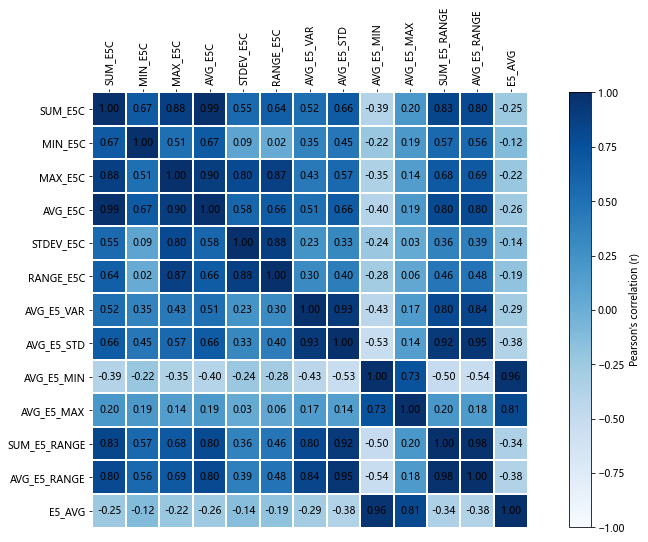

In [137]:
# Evaluate correlation of indicators with AVG(e5) and thus target class

# Join indicator columns with AVG(e5)
stations_num=stations_price_indicators.set_index("station_uuid").join(
             stations_class.drop('STATION_CLASS').set_index("station_uuid"))
#display(stations_num.head(5).collect())

# Avoid usage of intercorrelated indicators, e.g. correlate numerical columns
import matplotlib.pyplot as plt
from hana_ml.visualizers.eda import EDAVisualizer
f = plt.figure(figsize=(15, 8))
ax1 = f.add_subplot(111)
eda = EDAVisualizer(ax1)
ax1, corr = eda.correlation_plot(data=stations_num.drop('station_uuid'), cmap="Blues")
plt.show()

Due to high correlation with the "E5_AVG" column and intercorrelations (values higher than 0.5), we will exclude a number of features from the price indicators_dataframe.

In [138]:
# Drop high correlated indicator columns
stations_price_indicators=stations_price_indicators.drop('AVG_E5_MIN').drop('AVG_E5_MAX').drop('SUM_E5C').drop('AVG_E5C')
stations_price_indicators=stations_price_indicators.drop('AVG_E5_STD').drop('SUM_E5_RANGE').drop('AVG_E5_RANGE')
stations_price_indicators.head(3).collect()

,station_uuid,MIN_E5C,MAX_E5C,STDEV_E5C,RANGE_E5C,AVG_E5_VAR
0,00006210-0037-4444-8888-acdc00006210,10.0,38.0,5.267865,28.0,0.000894
1,00016899-3247-4444-8888-acdc00000007,1.0,14.0,2.573527,13.0,0.001109
2,00041414-208c-4444-8888-acdc00000414,1.0,4.0,0.55918,3.0,0.000255


# Ex 6.2 - Enrich fuel station classification data with spatial attributes

At first, we will driven a data-driven spatial hierarchy from the stations point locations using its geohashes. 
- Geohashes are unique hash-values derived from geo-locations, by ommitting trailing values from the 20 character hash-string. Simply a rectangle represented by the first 5 characters of the geohash, is guaranteed to contain to any rectangle / point represented by the same first 5 + n characters geohash.
- The generated_feature dataframe functions allows to generate a hierarchy geohash features.

In [139]:
# Create a station spatial hierarchy HANA dataframe
stations_spatialhierarchy = stations_hdf.select('uuid', 'longitude','latitude','longitude_latitude_GEO')

# Derive spatial hierarchy features from station point location
stations_spatialhierarchy =stations_spatialhierarchy.generate_feature(targets='longitude_latitude_GEO', 
                                                          trans_func='GEOHASH_HIERARCHY', trans_param=range(3,6))

# Rename columns
stations_spatialhierarchy=stations_spatialhierarchy.rename_columns({'GEOHASH_HIERARCHY(longitude_latitude_GEO,3)': 'GEO_H3', 
                                                                    'GEOHASH_HIERARCHY(longitude_latitude_GEO,4)': 'GEO_H4', 
                                                                    'GEOHASH_HIERARCHY(longitude_latitude_GEO,5)': 'GEO_H5'
                                                                   }
                                                                      )

stations_spatialhierarchy.head(2).collect()

,uuid,longitude,latitude,longitude_latitude_GEO,GEO_H3,GEO_H4,GEO_H5
0,064554c1-d960-444e-bc1b-0a0449711e44,13.301201,52.515933,POINT (13.301201 52.515933),u33,u336,u336y
1,0ba0e8ac-ae93-4a29-837c-165bfa0fac2f,9.275176,49.086426,POINT (9.275176 49.0864258),u0w,u0wx,u0wx5


Each stations closest distance to the network of highways in Germany as been pre-calcualted and can be imported from the file stations_hwaydist.csv
- Note in the [add-on exercises section]() it is described, how the Germany highway network can be imported using the OpenStreetMap network Python interface OSMNX, imported as HANA graph, a Multilinestring created for the complete highway network and the distance calculated.

In [140]:
# Import station distance to nearest highway and join with spatial hierarchy data
stations_hwaydist_pd = pd.read_csv('./data/fuelprice/stations_hwaydist.csv', sep=',', header=0, skiprows=1,
                                      names=["idx", "uuid", "HIGHWAY_DISTANCE"],
                                      usecols=["uuid", "HIGHWAY_DISTANCE"])
stations_hwaydist = create_dataframe_from_pandas(
        conn,
        stations_hwaydist_pd,
        schema='TECHED_USER_999',
        table_name="GAS_STATION_HWAYDIST",
        force=True,
        replace=True,
        drop_exist_tab=True,
        table_structure={"uuid": "NVARCHAR(5000)", "HIGHWAY_DISTANCE": "DOUBLE"}
    )
display(stations_hwaydist.head(5).collect())

# Joining distance data with spatial hierachy dataframe 
stations_spatial_attributes=stations_spatialhierarchy.set_index("uuid").join(stations_hwaydist.set_index("uuid"))
display(stations_spatial_attributes.collect())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


,uuid,HIGHWAY_DISTANCE
0,022c6e51-068e-4acf-a378-80a134829bdb,274.489123
1,033bce61-7584-45e7-94dd-952fd0b4899c,3996.271341
2,046fe959-53dd-4a2b-8fc1-c81f2e58df07,56.817501
3,05132bc9-c04f-42a9-8de8-76de9d2b368b,990.345153
4,07372cb6-e38e-4fe8-9a5b-2a44a56446e2,2254.582830


,uuid,longitude,latitude,longitude_latitude_GEO,GEO_H3,GEO_H4,GEO_H5,HIGHWAY_DISTANCE
0,064554c1-d960-444e-bc1b-0a0449711e44,13.301201,52.515933,POINT (13.301201 52.515933),u33,u336,u336y,1645.160921
1,0ba0e8ac-ae93-4a29-837c-165bfa0fac2f,9.275176,49.086426,POINT (9.275176 49.0864258),u0w,u0wx,u0wx5,1563.534288
2,2020d9be-d9db-456f-9bd1-c72f3ad5d279,13.371043,52.470024,POINT (13.3710432 52.4700241),u33,u33d,u33d2,83.247604
3,2acc4724-ea6a-4874-baa6-e191ccb12756,11.617154,48.114907,POINT (11.617154 48.114907),u28,u283,u2838,440.535554
4,3c57e143-470c-4130-b8ea-0a775e5f081c,10.644375,47.898714,POINT (10.644375 47.898714),u0x,u0x8,u0x86,14796.489669
...,...,...,...,...,...,...,...,...
13829,47cb85c6-6eed-4c91-bd7d-d5f9efe3a49c,10.476800,51.634100,POINT (10.4768 51.6341),u1p,u1pm,u1pmw,23531.389246
13830,5e032abb-acfe-4b08-ac77-0497dca223d4,6.834332,50.914758,POINT (6.834332000000001 50.914758),u1h,u1hc,u1hce,1043.648335
13831,8fc5939b-e842-4094-88e7-dd5897ea9a65,9.568151,53.590950,POINT (9.568151 53.59095),u1w,u1wb,u1wbc,23199.284156
13832,d0235369-10e6-4862-8b27-66c03ddace6b,9.923700,53.564240,POINT (9.9237 53.56424000000001),u1x,u1x0,u1x09,1976.629727


Finally we spatially join the stations spatial attributes dataframe with the German-region "Landkreise" shape and select __relevant region attributes__.

In [141]:
# Create station spatial dataframe joining spatial hierachy and regions attributes
regions_hdf = conn.table("GEO_GERMANY_REGIONS")

# Joins regions and stations via HANA spatial join-function
stations_spatial = stations_spatial_attributes.join(regions_hdf.select('lan_name','krs_name','krs_type','SHAPE'), 
       '"longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1')

stations_spatial.drop('SHAPE').head(5).collect()

,uuid,longitude,latitude,longitude_latitude_GEO,GEO_H3,GEO_H4,GEO_H5,HIGHWAY_DISTANCE,lan_name,krs_name,krs_type
0,7d8ba49c-b9ec-4672-b76f-251b3065b9af,13.432754,52.558410,POINT (13.432754 52.55840999999999),u33,u33d,u33dc,2503.696128,Berlin,Kreisfreie Stadt Berlin,Kreisfreie Stadt
1,8647598f-6e3d-4c61-8c81-4def37468433,9.770800,52.358510,POINT (9.770799999999999 52.35851),u1q,u1qc,u1qcy,7390.474690,Niedersachsen,Landkreis Region Hannover,Landkreis
2,885142e0-ee17-4614-bdc0-737a90154a87,10.850390,51.367960,POINT (10.85039 51.36796),u1p,u1ps,u1psn,10465.863868,Thüringen,Landkreis Kyffhäuserkreis,Landkreis
3,89209f7d-026b-4237-fa8f-a0e1e646994d,8.374411,52.609473,POINT (8.374411 52.609473),u1m,u1mg,u1mgq,23780.388005,Niedersachsen,Landkreis Diepholz,Landkreis
4,8b7fe728-dca6-5e6b-9232-528b275507df,10.731700,53.090099,POINT (10.73169994354 53.09009933472),u1r,u1rw,u1rwh,42045.112405,Niedersachsen,Landkreis Uelzen,Landkreis


# Ex 6.3 - Build fuel station classification model and evaluate impact of attributes

__Step 1 - Create the station classification HANA dataframe__  
For conveniance, we first save the station dataframes as local temporary tables in SAP HANA.

In [142]:
# Save station attributes dataframes to temporary HANA tables
stations_class.drop('E5_AVG').save('#STATION_CLASS', force=True)
station_master.save('#STATION_MASTER', force=True)
stations_price_indicators.save('#STATION_PRICE_INDICATORS', force=True)
stations_spatial.drop('longitude_latitude_GEO').drop('SHAPE').save('#STATION_SPATIAL', force=True)



Using an advance join SQL statement of all the attributes temporary table, we create the stations priceclass dataframe.

In [143]:
# Build the classification training data HANA dataframe
stations_priceclass=conn.sql(
"""
SELECT M."uuid", "brand", "post_code2", "post_code3", "city", 
       "longitude", "latitude", "GEO_H3", "GEO_H4", "GEO_H5", "lan_name", "krs_name", "krs_type",
       S.HIGHWAY_DISTANCE,
       "MIN_E5C", "MAX_E5C", "STDEV_E5C", "RANGE_E5C", "AVG_E5_VAR",  
       "STATION_CLASS"
   From #STATION_MASTER as M,
        #STATION_SPATIAL as S,
        #STATION_PRICE_INDICATORS as PI,
        #STATION_CLASS as C
    Where M."uuid"=PI."station_uuid" AND 
          M."uuid"=S."uuid" AND
          M."uuid"=C."station_uuid";
"""
)
stations_priceclass.head(3).collect()
#print(stations_priceclass.columns)
#6.3.1-price_class_dataset.png

,uuid,brand,post_code2,post_code3,city,longitude,latitude,GEO_H3,GEO_H4,GEO_H5,lan_name,krs_name,krs_type,HIGHWAY_DISTANCE,MIN_E5C,MAX_E5C,STDEV_E5C,RANGE_E5C,AVG_E5_VAR,STATION_CLASS
0,a1ea6437-ddbc-4f1c-a5bb-2b5fa33f8e7e,ARAL,07,074,Rudolstadt,11.364309,50.727196,u30,u300,u300d,Thüringen,Landkreis Saalfeld-Rudolstadt,Landkreis,20680.295051,11.0,36.0,4.29001,25.0,0.001282,5
1,3aeed500-8dda-4bd8-be55-d13e415e81b1,ARAL,55,557,Baumholder,7.328758,49.609330,u0v,u0v4,u0v4n,Rheinland-Pfalz,Landkreis Birkenfeld,Landkreis,8353.890220,11.0,33.0,3.862148,22.0,0.001471,4
2,8f4cc878-7eec-4d36-8fd6-30a6257204c6,ARAL,34,342,Melsungen,9.537404,51.128956,u1n,u1nf,u1nfc,Hessen,Landkreis Schwalm-Eder-Kreis,Landkreis,5996.114674,14.0,30.0,3.35904,16.0,0.001387,4


Which we then save to as our model development base dataset.

In [144]:
# Save station classification dataset to HANA column table
stations_priceclass.save('STATION_PRICECLASSIFICATION', force=True)

gas_station_class_base = conn.table("STATION_PRICECLASSIFICATION", schema="TECHED_USER_999")
gas_station_class_base.head(5).collect()

,uuid,brand,post_code2,post_code3,city,longitude,latitude,GEO_H3,GEO_H4,GEO_H5,lan_name,krs_name,krs_type,HIGHWAY_DISTANCE,MIN_E5C,MAX_E5C,STDEV_E5C,RANGE_E5C,AVG_E5_VAR,STATION_CLASS
0,064554c1-d960-444e-bc1b-0a0449711e44,Shell,10,105,BERLIN,13.301201,52.515933,u33,u336,u336y,Berlin,Kreisfreie Stadt Berlin,Kreisfreie Stadt,1645.160921,8.0,26.0,2.797363,18.0,0.001607,4
1,0ba0e8ac-ae93-4a29-837c-165bfa0fac2f,ARAL,74,741,Untergruppenbach,9.275176,49.086426,u0w,u0wx,u0wx5,Baden-Württemberg,Landkreis Heilbronn,Landkreis,1563.534288,14.0,34.0,3.555145,20.0,0.001519,4
2,2020d9be-d9db-456f-9bd1-c72f3ad5d279,ARAL,12,121,Berlin,13.371043,52.470024,u33,u33d,u33d2,Berlin,Kreisfreie Stadt Berlin,Kreisfreie Stadt,83.247604,15.0,37.0,3.852876,22.0,0.002164,5
3,2acc4724-ea6a-4874-baa6-e191ccb12756,Shell,81,816,MUENCHEN,11.617154,48.114907,u28,u283,u2838,Bayern,Kreisfreie Stadt München,Kreisfreie Stadt,440.535554,13.0,34.0,3.6147,21.0,0.001637,5
4,3c57e143-470c-4130-b8ea-0a775e5f081c,Shell,87,876,KAUFBEUREN,10.644375,47.898714,u0x,u0x8,u0x86,Bayern,Kreisfreie Stadt Kaufbeuren,Kreisfreie Stadt,14796.489669,2.0,24.0,3.076896,22.0,0.001943,4


__Step 2 - Splitting up our base dataset__  
In order to validate during training and test our finally derived classification model on data not used during training, we split up or base data set into train-, validation- and test-subsets.

In [145]:
# Split the station classification dataframe into a training and test subset
from hana_ml.algorithms.pal.partition import train_test_val_split
df_train, df_test, df_val = train_test_val_split(data=gas_station_class_base, id_column='uuid',
                                            random_seed=2, partition_method='stratified', stratified_column='STATION_CLASS',
                                            training_percentage=0.70,
                                            testing_percentage=0.15,
                                            validation_percentage=0.15)

df_train.describe().collect()
#print(df_train.describe().select_statement)
#6.3.3-price_train_describe.png

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,longitude,9686,9672,0,9.629508,2.020061,5.901075,14.983898,9.325267,8.055480,8.055264,9.325267,9.325244,11.090115,11.090400
1,latitude,9686,9637,0,50.876110,1.748484,47.399570,55.015890,51.012960,49.417792,49.417221,51.012960,51.012750,52.199517,52.199580
2,HIGHWAY_DISTANCE,9686,9684,0,8608.002760,10126.803024,4.236829,110573.524354,4712.924384,1718.456775,1718.397420,4712.924384,4711.595974,11916.871356,11917.109183
3,MIN_E5C,9686,32,0,9.596634,6.267147,1.000000,38.000000,11.000000,3.000000,3.000000,11.000000,11.000000,14.000000,14.000000
4,MAX_E5C,9686,99,0,33.945901,12.388562,2.000000,157.000000,35.000000,29.000000,29.000000,35.000000,35.000000,40.000000,40.000000
5,STDEV_E5C,9686,9465,0,4.328985,1.898725,0.162221,29.591186,4.191888,3.402540,3.402200,4.191888,4.191817,5.095692,5.095961
6,RANGE_E5C,9686,89,0,24.349267,10.637304,1.000000,151.000000,23.000000,19.000000,19.000000,23.000000,23.000000,30.000000,30.000000
7,AVG_E5_VAR,9686,9650,0,0.001463,0.000538,0.000000,0.012346,0.001494,0.001232,0.001232,0.001494,0.001494,0.001771,0.001771
8,STATION_CLASS,9686,10,0,4.296923,0.804738,1.000000,10.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
9,uuid,9686,9686,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As the describe column report of our training subset shows, some of the columns contains null values (brand, post_code). During model training, we will take of this.   
  
In order to validate our trained model, with the previous step determined validation subset, we union both dataframes to be trianing input.

In [146]:
# Union train and validation data into one set
df_trainval=df_train.select('*', ('1', 'TRAIN_VAL_INDICATOR' )).union(df_val.select('*', ('2', 'TRAIN_VAL_INDICATOR' )))

display(df_trainval.head(5).collect())

,uuid,brand,post_code2,post_code3,city,longitude,latitude,GEO_H3,GEO_H4,GEO_H5,...,krs_name,krs_type,HIGHWAY_DISTANCE,MIN_E5C,MAX_E5C,STDEV_E5C,RANGE_E5C,AVG_E5_VAR,STATION_CLASS,TRAIN_VAL_INDICATOR
0,0ba0e8ac-ae93-4a29-837c-165bfa0fac2f,ARAL,74,741,Untergruppenbach,9.275176,49.086426,u0w,u0wx,u0wx5,...,Landkreis Heilbronn,Landkreis,1563.534288,14.0,34.0,3.555145,20.0,0.001519,4,1
1,60abebe5-e51d-4bf1-a96b-f4b9a17dfa49,ARAL,88,882,Ravensburg,9.598375,47.738570,u0q,u0qz,u0qzd,...,Landkreis Ravensburg,Landkreis,19548.286656,12.0,30.0,3.27681,18.0,0.001369,4,1
2,022c6e51-068e-4acf-a378-80a134829bdb,ARAL,55,554,Rheinböllen,7.683820,49.996162,u0v,u0vk,u0vkq,...,Landkreis Rhein-Hunsrück-Kreis,Landkreis,274.489123,10.0,26.0,3.000402,16.0,0.000688,4,1
3,0ae68f77-faea-4dc8-bdc7-5525185bd4e4,ARAL,55,554,Bingen,7.933970,49.926163,u0v,u0vs,u0vsh,...,Landkreis Mainz-Bingen,Landkreis,402.242012,14.0,33.0,3.323383,19.0,0.001347,4,1
4,42bb859e-88d8-4d95-8402-e836d29f060f,ARAL,34,343,HOFGEISMAR,9.389930,51.481434,u1n,u1ns,u1nsv,...,Landkreis Kassel,Landkreis,17337.664875,16.0,37.0,4.605282,21.0,0.001834,4,1


__Step 3 - Train the station price-class classification model__  
We now use the [PAL Unified Classification method](https://help.sap.com/doc/1d0ebfe5e8dd44d09606814d83308d4b/latest/en-US/hana_ml.algorithms.pal_algorithm.html?highlight=unified%20classification#module-hana_ml.algorithms.pal.unified_classification), to train a [HybridGradientBoostingTree](https://help.sap.com/docs/HANA_CLOUD_DATABASE/319d36de4fd64ac3afbf91b1fb3ce8de/ca5106cbd88f4ac69e7538bbc6a059ea.html?locale=en-US) classifier model.

In [147]:
# Train the Station classifer model using PAL HybridGradientBoostingTree
from hana_ml.algorithms.pal.unified_classification import UnifiedClassification

# Initialize the model object 
hgbc = UnifiedClassification(func='HybridGradientBoostingTree',
                            n_estimators = 101, split_threshold=0.1,
                            learning_rate=0.5, max_depth=5,
                            resampling_method='cv',fold_num=5, ref_metric=['auc'],
                            evaluation_metric = 'error_rate',
                            thread_ratio=1.0)

# Execute the training of the model
hgbc.fit(data=df_trainval, key= 'uuid',
         label='STATION_CLASS', categorical_variable='STATION_CLASS',
         impute=True, strategy='most_frequent-mean',
         ntiles=20,  build_report=True,
         partition_method='user_defined', purpose='TRAIN_VAL_INDICATOR' )
# partition_method='user_defined', purpose='TRAIN_VAL_INDICATOR'
#partition_method='stratified', stratified_column='STATION_CLASS', partition_random_state=1,

display(hgbc.runtime)
#235, 204

# Explore the feature importance result
#display(hgbc.importance_.sort('IMPORTANCE', desc=True).collect().set_index('VARIABLE_NAME'))

11.798120260238647

__Step 4 - Explore the model report and attribute importance__  
Using the __model report__, we can now explore training and validation model performance statistics, confusion matrix, explore feature importance and classification metric reports like ROC, gain or lift charts.  
Finally, looking the __feature importance__-section of the report, the relative importance of all attributes explaining and contributing to the models global classification performance is reported.

In [148]:
# Build Model Report
from hana_ml.visualizers.unified_report import UnifiedReport
UnifiedReport(hgbc).build().display()

In order to review the unified classification model report better, you need to adjust the size of the left area or hide the left area temporarily!


  
Applying the __model PREDICT-method__ with potential new station data, our test-data or any stations data, beside the models predicted classification for a station, we can review a __station's attributes value importance with respect to the predicted classification__ (local feature importance or explainability) in the REASON_CODE column output.

In [149]:
# Explore test data-subset predictions applying the trained model
features = df_test.columns
features.remove('STATION_CLASS')
features.remove('uuid')
 
# Using the PREDICT-method with our model object hgbc
pred_res = hgbc.predict(df_test.head(1000), 
                        key='uuid', features=features, impute=True, 
                        thread_ratio=1.0)

display(hgbc.runtime)

# Review the predicted results
pd.set_option('max_colwidth', None)
pred_res.select('uuid', 'SCORE', 'CONFIDENCE', 'REASON_CODE', 
                ('json_query("REASON_CODE", \'$[0].attr\')', 'Top1'), 
                ('json_query("REASON_CODE", \'$[0].pct\')', 'PCT_1') ).head(3).collect()

113.87838983535767

,uuid,SCORE,CONFIDENCE,REASON_CODE,Top1,PCT_1
0,1ad20106-b7cd-42d9-a15e-7f22a5578ccf,4,0.918798,"[{""attr"":""brand"",""val"":-0.4579817994788751,""pct"":33.46007795526957},{""attr"":""latitude"",""val"":0.19768066142741107,""pct"":14.442517910399017},{""attr"":""STDEV_E5C"",""val"":-0.14999808593868034,""pct"":10.958836474201356},{""attr"":""longitude"",""val"":0.11881036588998675,""pct"":8.680266571939236},{""attr"":""MAX_E5C"",""val"":0.10826692779645163,""pct"":7.909964649619031},{""attr"":""MIN_E5C"",""val"":0.07620188699255427,""pct"":5.567297831509387},{""attr"":""AVG_E5_VAR"",""val"":-0.06486113993777591,""pct"":4.738744642374671},{""attr"":""HIGHWAY_DISTANCE"",""val"":0.055791304621593009,""pct"":4.076103906288094},{""attr"":""RANGE_E5C"",""val"":-0.034651212924808567,""pct"":2.531612144910617},{""attr"":""GEO_H3"",""val"":0.02479756233621844,""pct"":1.8117059887852547}]","""brand""",33.46007795526957
1,2b6e76d3-486f-4fae-a498-d8a20b33bae9,4,0.923238,"[{""attr"":""brand"",""val"":-0.4229069421242863,""pct"":38.74539805025235},{""attr"":""latitude"",""val"":0.20925648284178553,""pct"":19.17141790478823},{""attr"":""lan_name"",""val"":0.07960421201994583,""pct"":7.293086431016905},{""attr"":""MAX_E5C"",""val"":0.07436548197907163,""pct"":6.813130534119298},{""attr"":""AVG_E5_VAR"",""val"":-0.065992253029606,""pct"":6.046001749277553},{""attr"":""STDEV_E5C"",""val"":0.0608002223459586,""pct"":5.570324299963132},{""attr"":""HIGHWAY_DISTANCE"",""val"":0.05738302966650196,""pct"":5.257251901778083},{""attr"":""GEO_H3"",""val"":0.025408598875874847,""pct"":2.3278555617931775},{""attr"":""city"",""val"":0.020021974172363525,""pct"":1.8343500231124417},{""attr"":""RANGE_E5C"",""val"":-0.019725748545815968,""pct"":1.8072107670018208}]","""brand""",38.74539805025235
2,7c29854d-6952-4eb6-8151-3f79cad8fb6c,4,0.885690,"[{""attr"":""brand"",""val"":-0.4564691658270823,""pct"":30.334371461454574},{""attr"":""latitude"",""val"":0.37732099909824798,""pct"":25.0746297969867},{""attr"":""AVG_E5_VAR"",""val"":0.14617871145281167,""pct"":9.714214376193228},{""attr"":""longitude"",""val"":-0.09831744243446097,""pct"":6.533623830961882},{""attr"":""post_code3"",""val"":-0.06986293588974643,""pct"":4.642697486099552},{""attr"":""post_code2"",""val"":-0.06485008379155227,""pct"":4.30957155118031},{""attr"":""STDEV_E5C"",""val"":0.05540331148605774,""pct"":3.681792236212939},{""attr"":""HIGHWAY_DISTANCE"",""val"":0.05519356861537003,""pct"":3.667853905593598},{""attr"":""lan_name"",""val"":0.05281631388035254,""pct"":3.509874936609218},{""attr"":""GEO_H3"",""val"":0.025460424975513663,""pct"":1.6919565363727026}]","""brand""",30.334371461454574


# Optional Add-on exercises

## Score and debrief model

Using the Unified Classification-SCORE method, we can benchmark and test our models generalization against data completely unseen during model development.

In [150]:
# Test model generalization using the test data-subset, not used during training
scorepredictions, scorestats, scorecm, scoremetrics = hgbc.score(data=df_test.head(100) , key= 'uuid', label='STATION_CLASS', 
                                                                 ntiles=20, impute=True,
                                                                 thread_ratio=1.0)
#display(hgbc.runtime)
display(scorestats.sort('CLASS_NAME').collect())
display(scorecm.filter('COUNT != 0').collect())
#display(scoremetrics.collect())

,STAT_NAME,STAT_VALUE,CLASS_NAME
0,ACCURACY,0.9,None
1,KAPPA,0,None
2,RECALL,0.9,4
3,PRECISION,1,4
4,F1_SCORE,0.9473684210526316,4
5,SUPPORT,100,4
6,RECALL,0,5
7,PRECISION,0,5
8,F1_SCORE,0,5
9,SUPPORT,0,5


,ACTUAL_CLASS,PREDICTED_CLASS,COUNT
0,4,4,90
1,4,5,10


The Shapley explainer plot, shows the distribution each feature has on the model predictions.

1.Using Shapley values to show the distribution of the impacts each feature has on the model output.
2.The color represents the feature value (red high, blue low).
3.The plot below shows the relationship between feature value and Shapley value.
-- If the dots in the left area are blue and the dots in the right area are red, then it means that the feature value and the Shapley value are typically positive correlation.
-- If the dots in the left area are red and the dots in the right area are blue, then it means that the feature value and the Shapley value are typically negative correlation.
-- If all the dots are concentrated near 0, it means that the Shapley value has nothing to do with this feature.


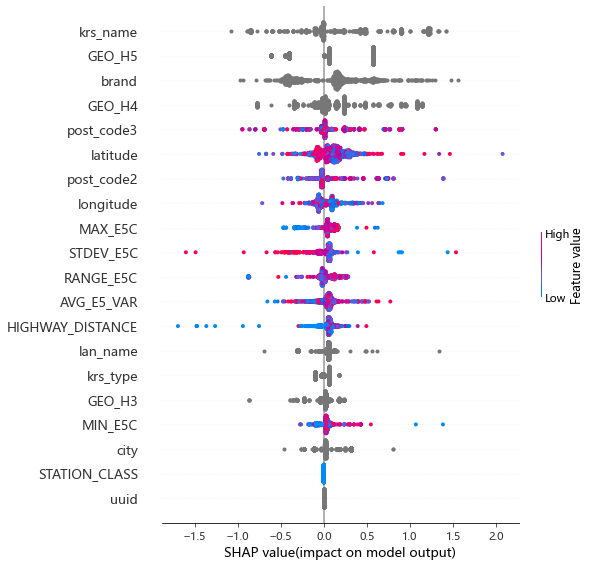

In [123]:
#  Show the distribution of the impacts each feature has on the model output using Shapley ML explainability values 
import pydotplus
import graphviz
from hana_ml.visualizers.model_debriefing import TreeModelDebriefing

shapley_explainer = TreeModelDebriefing.shapley_explainer(pred_res.head(1000), df_test.head(1000), 
                                                          key='uuid', label='STATION_CLASS')
shapley_explainer.summary_plot()

The features that were important to making the prediction for this observation are shown in red and blue, with red representing features that pushed the model score higher, and blue representing features that pushed the score lower. Features that had more of an impact on the score are located closer to the dividing boundary between red and blue, and the size of that impact is represented by the size of the bar.

In [162]:
# Show the "local" distribution impact of each feature for individual predictions 
shapley_explainer = TreeModelDebriefing.shapley_explainer(pred_res.head(50), df_test.fillna('missing').head(50), 
                                                          key='uuid', label='STATION_CLASS')
shapley_explainer.force_plot()


## Store model and retrieve stored models and model reports

Using the ModelStorage methods, we can store and retrieve models and model performance reports from a given storage schema.

In [158]:
# Initiate ModelStorage location
from hana_ml.model_storage import ModelStorage
MLLAB_models = ModelStorage(connection_context=conn, schema="TECHED_USER_999")

#Describe and save current model
hgbc.name = 'STATION PRICE-CLASS CLASSIFIER MODEL' 
hgbc.version = 1

MLLAB_models.save_model(model=hgbc)


In [159]:
# Retrieve model from ModelStorage location
from hana_ml.model_storage import ModelStorage
MLLAB_models = ModelStorage(connection_context=conn)

list_models = MLLAB_models.list_models()
display(list_models)

,NAME,VERSION,LIBRARY,CLASS,JSON,TIMESTAMP,STORAGE_TYPE,MODEL_STORAGE_VER,SCHEDULE,MODEL_REPORT
0,STATION PRICE-CLASS CLASSIFIER MODEL,1,PAL,hana_ml.algorithms.pal.unified_classification.UnifiedClassification,"{""model_attributes"": {""func"": ""HybridGradientBoostingTree"", ""multi_class"": null, ""massive"": false, ""group_params"": null, ""kwargs"": {""n_estimators"": 101, ""split_threshold"": 0.1, ""learning_rate"": 0.5, ""max_depth"": 5, ""resampling_method"": ""cv"", ""fold_num"": 5, ""ref_metric"": [""auc""], ""evaluation_metric"": ""error_rate"", ""thread_ratio"": 1.0}}, ""fit_params"": {""key"": ""uuid"", ""features"": null, ""label"": ""STATION_CLASS"", ""group_key"": null, ""group_params"": null, ""purpose"": ""TRAIN_VAL_INDICATOR"", ""partition_method"": ""user_defined"", ""stratified_column"": null, ""partition_random_state"": null, ""training_percent"": null, ""training_size"": null, ""ntiles"": 20, ""categorical_variable"": ""STATION_CLASS"", ""output_partition_result"": null, ""background_size"": null, ""background_random_state"": null, ""build_report"": true, ""impute"": true, ""strategy"": ""most_frequent-mean"", ""strategy_by_col"": null, ""als_factors"": null, ""als_lambda"": null, ""als_maxit"": null, ""als_randomstate"": null, ""als_exit_threshold"": null, ""als_exit_interval"": null, ""als_linsolver"": null, ""als_cg_maxit"": null, ""als_centering"": null, ""als_scaling"": null, ""kwargs"": {}}, ""artifacts"": {""schema"": ""TECHED_USER_999"", ""model_tables"": [""HANAML_STATION_PRICE-CLASS_CLASSIFIER_MODEL_1_MODELS_0"", ""HANAML_STATION_PRICE-CLASS_CLASSIFIER_MODEL_1_MODELS_1"", ""HANAML_STATION_PRICE-CLASS_CLASSIFIER_MODEL_1_MODELS_2"", ""HANAML_STATION_PRICE-CLASS_CLASSIFIER_MODEL_1_MODELS_3"", ""HANAML_STATION_PRICE-CLASS_CLASSIFIER_MODEL_1_MODELS_4"", ""HANAML_STATION_PRICE-CLASS_CLASSIFIER_MODEL_1_MODELS_5""], ""library"": ""PAL""}, ""pal_meta"": {""_fit_param"": [[""FUNCTION"", ""HGBT"", ""string""], [""KEY"", 1, ""integer""], [""N_ESTIMATORS"", 101, ""integer""], [""SPLIT_THRESHOLD"", 0.1, ""float""], [""LEARNING_RATE"", 0.5, ""float""], [""MAX_DEPTH"", 5, ""integer""], [""RESAMPLING_METHOD"", ""cv"", ""string""], [""FOLD_NUM"", 5, ""integer""], [""REF_METRIC"", ""AUC"", ""string""], [""EVALUATION_METRIC"", ""ERROR_RATE"", ""string""], [""THREAD_RATIO"", 1.0, ""float""], [""PARTITION_METHOD"", 1, ""integer""], [""NTILES"", 20, ""integer""], [""HANDLE_MISSING_VALUE"", 1, ""integer""], [""IMPUTATION_TYPE"", 1, ""integer""], [""CATEGORICAL_VARIABLE"", ""STATION_CLASS"", ""string""]], ""_predict_param"": [[""FUNCTION"", ""HGBT"", ""string""], [""THREAD_RATIO"", 1.0, ""float""], [""HANDLE_MISSING_VALUE"", 1, ""integer""]], ""fit_data_struct"": {""uuid"": ""NVARCHAR(5000)"", ""brand"": ""NVARCHAR(5000)"", ""post_code2"": ""NVARCHAR(2)"", ""post_code3"": ""NVARCHAR(3)"", ""city"": ""NVARCHAR(5000)"", ""longitude"": ""DOUBLE"", ""latitude"": ""DOUBLE"", ""GEO_H3"": ""NVARCHAR(5000)"", ""GEO_H4"": ""NVARCHAR(5000)"", ""GEO_H5"": ""NVARCHAR(5000)"", ""lan_name"": ""NVARCHAR(255)"", ""krs_name"": ""NVARCHAR(255)"", ""krs_type"": ""NVARCHAR(255)"", ""HIGHWAY_DISTANCE"": ""DOUBLE"", ""MIN_E5C"": ""DOUBLE"", ""MAX_E5C"": ""DOUBLE"", ""STDEV_E5C"": ""DECIMAL(25, 6)"", ""RANGE_E5C"": ""DOUBLE"", ""AVG_E5_VAR"": ""DOUBLE"", ""STATION_CLASS"": ""INT"", ""TRAIN_VAL_INDICATOR"": ""INT""}, ""predict_data_struct"": {""uuid"": ""NVARCHAR(5000)"", ""brand"": ""NVARCHAR(5000)"", ""post_code2"": ""NVARCHAR(2)"", ""post_code3"": ""NVARCHAR(3)"", ""city"": ""NVARCHAR(5000)"", ""longitude"": ""DOUBLE"", ""latitude"": ""DOUBLE"", ""GEO_H3"": ""NVARCHAR(5000)"", ""GEO_H4"": ""NVARCHAR(5000)"", ""GEO_H5"": ""NVARCHAR(5000)"", ""lan_name"": ""NVARCHAR(255)"", ""krs_name"": ""NVARCHAR(255)"", ""krs_type"": ""NVARCHAR(255)"", ""HIGHWAY_DISTANCE"": ""DOUBLE"", ""MIN_E5C"": ""DOUBLE"", ""MAX_E5C"": ""DOUBLE"", ""STDEV_E5C"": ""DECIMAL(25, 6)"", ""RANGE_E5C"": ""DOUBLE"", ""AVG_E5_VAR"": ""DOUBLE""}, ""label"": ""STATION_CLASS""}}",2

At a later point in time, we can reconnect to the ModelStorage schema, retrieve stored models and revisit model reports

In [160]:
# Retrieve model from ModelStorage location
from hana_ml.model_storage import ModelStorage
MLLAB_models = ModelStorage(connection_context=conn, schema="TECHED_USER_999")

# Reload model from ModelStorage
mymodel = MLLAB_models.load_model('STATION PRICE-CLASS CLASSIFIER MODEL', 1)

# Predict with reloaded model
pred_results=mymodel.predict(data=df_test.head(10), key='uuid', features=features, impute=True)

# Build Model Report
from hana_ml.visualizers.unified_report import UnifiedReport
UnifiedReport(mymodel).build().display()

In order to review the unified classification model report better, you need to adjust the size of the left area or hide the left area temporarily!


As needed, models and the complete model storage can be deleted as needed and database authorizations allow for.

In [157]:
# CleanUp Model Storage
MLLAB_models.delete_models(name='STATION PRICE-CLASS CLASSIFIER MODEL')
MLLAB_models.clean_up()


## Use OSMNX to import German Highway network and calculate spatial distance btw station and next highway

OSMNX is a Python package that lets you download geospatial data from OpenStreetMap and model, project, visualize, and analyze real-world street networks and any other geospatial geometries. You can download and model walkable, drivable, or bikeable urban networks with a single line of Python code then easily analyze and visualize them. You can just as easily download and work with other infrastructure types, amenities/points of interest, building footprints, elevation data, street bearings/orientations, and speed/travel time.See https://osmnx.readthedocs.io/en/stable/index.html for reference details.

There are multiple methods to download street network data, like  "graph from place" or "graph from polygon".  
! Be careful, downloading the german highway network via OSMNX takes multiple hours.  
! There if you seek to explore this section, try out the next step and download only the highway network for a single region instead.

In [73]:
%%time
import osmnx as ox

# Use OSMNX-method to download network graph from "place"
ox.config(use_cache=True, log_console=True)
cf = '["highway"~"motorway"]'

# !!careful, downloading the german highway network via OSMNX takes multiple hours
# If you want to try this out, try out the next step instead download the highway network for a single region

#g =  ox.graph_from_place('Germany', network_type = 'drive', custom_filter=cf)


Wall time: 16 s


  
Use OSMNX to download only the highway network for a single region.

In [ ]:
%%time
import osmnx as ox
hdf_RNK_SHAPE = stations_spatial.filter("\"krs_name\"='Landkreis Rhein-Neckar-Kreis'" ).select('uuid','krs_name', 'SHAPE').head(1)
display(hdf_RNK_SHAPE.drop('SHAPE').collect())

# Create Geopandas Dataframe from the HANA dataframe
gdf_RNK_SHAPE = gpd.GeoDataFrame(hdf_RNK_SHAPE.select('uuid', 'SHAPE').collect(), geometry='SHAPE')
gdf_RNK_SHAPE=gdf_RNK_SHAPE.rename_geometry('geometry')
display(gdf_RNK_SHAPE.head(10))

# Use OSMNX-method to download network graph from polygon
ox.config(use_cache=True, log_console=True)
cf = '["highway"~"motorway"]'
g = ox.graph_from_polygon(polygon = gdf_RNK_SHAPE['geometry'][0], network_type = 'drive',custom_filter=cf)
#fig, ax = ox.plot_graph(g, fig_height=5)


Check if the network graph object has been successfully downloaded and stored as dataframe "g" 

In [ ]:
# Check successful object download
g

# Plot OSMNX highway network graph data
fig, ax = ox.plot_graph(g)
#6.2.4-osmx_highway_plot.png

Load graph nodes and edges into geopandas dataframes

In [ ]:
# Create geodataframes from network graph
gdf_nodes,gdf_edges = ox.graph_to_gdfs(g, nodes=True, edges=True)
gdf_edges
#6.2.5-gdf_edges.png

In order to load the graph dataframes into SAP HANA, the network arrays from the geopandas dataframe require to be str-column converted into pandas dataframes

In [ ]:
# Convert network arrays to str-column format for the pandas dataframe
gdf_edges['ID'] = np.arange(len(gdf_edges))
gdf_edges['osmid']=gdf_edges['osmid'].astype(str)
gdf_edges['ref']=gdf_edges['ref'].astype(str)
gdf_edges['highway']=gdf_edges['highway'].astype(str)

# Create a pandas dataframe, needed for the HANA dataframe import
pd_edges=pd.DataFrame(gdf_edges, copy=True)[['ID', 'osmid', 'geometry', 'highway','ref']]
pd_edges.head(5)
#6.2.6-pd_edges.png

Create the HANA dataframe for the street network edges

In [ ]:
# Create a HANA dataframe from the German highway-network edges pandas dataframe 
from hana_ml.dataframe import create_dataframe_from_pandas

hdf = create_dataframe_from_pandas(
    connection_context=conn, replace=True,
    pandas_df=pd_edges,
    geo_cols=["geometry"],
    srid=4326,
    schema='TECHED_USER_999',
    table_name="GEO_GERMANY_HIGHWAYS", primary_key='ID'
    , drop_exist_tab=True, force=True)

german_highways = conn.sql('select * from "TECHED_USER_999"."GEO_GERMANY_HIGHWAYS"')
german_highways.head(3).collect()
#6.2.7-german_highway_edges_hdf.png

In order to calculate the distance btw station and Germany highway network, we create a list or German region "Landkreis" area, so we calculate the distance in batches of stations within a regional area.

In [35]:
df=stations_spatial.distinct('krs_name').collect()
krs=list(set(list(df['krs_name'])))
print(sorted(krs))
#6.2.8-german_landkreis_liste.png

['Kreis Borken', 'Kreis Coesfeld', 'Kreis Dithmarschen', 'Kreis Düren', 'Kreis Ennepe-Ruhr-Kreis', 'Kreis Euskirchen', 'Kreis Gütersloh', 'Kreis Heinsberg', 'Kreis Herford', 'Kreis Herzogtum Lauenburg', 'Kreis Hochsauerlandkreis', 'Kreis Höxter', 'Kreis Kleve', 'Kreis Lippe', 'Kreis Mettmann', 'Kreis Minden-Lübbecke', 'Kreis Märkischer Kreis', 'Kreis Nordfriesland', 'Kreis Oberbergischer Kreis', 'Kreis Olpe', 'Kreis Ostholstein', 'Kreis Paderborn', 'Kreis Pinneberg', 'Kreis Plön', 'Kreis Recklinghausen', 'Kreis Rendsburg-Eckernförde', 'Kreis Rhein-Erft-Kreis', 'Kreis Rhein-Kreis Neuss', 'Kreis Rhein-Sieg-Kreis', 'Kreis Rheinisch-Bergischer Kreis', 'Kreis Schleswig-Flensburg', 'Kreis Segeberg', 'Kreis Siegen-Wittgenstein', 'Kreis Soest', 'Kreis Steinburg', 'Kreis Steinfurt', 'Kreis Stormarn', 'Kreis Städteregion Aachen', 'Kreis Unna', 'Kreis Viersen', 'Kreis Warendorf', 'Kreis Wesel', 'Kreisfreie Stadt Amberg', 'Kreisfreie Stadt Ansbach', 'Kreisfreie Stadt Aschaffenburg', 'Kreisfreie St

Using this SQL statements
- we precalculate a single multilinestring for the complete German highway network
- then calculate the distance between the multilinestring and the station points using the HANA spatial function ST_DISTANCE, we select the stations in batches of "Landkreis" regions
- store the calculated disctance to a table

In [ ]:
#SQL

#Calculate single Highway-Multilinestring from Highway network into temporary table #HWL
CREATE LOCAL TEMPORARY COLUMN TABLE #HWL ( HIGHWAY NVARCHAR(24), HIGHWAY_LINE ST_GEOMETRY(4326));
--#ALTER TABLE HWAY ALTER (HIGHWAY_LINE ST_GEOMETRY(4326));
INSERT INTO #HWL
	SELECT "highway",  NEW ST_MultiLineString('MultiLineString (' || substring(LSTRING,3) || ')', 4326) AS HIGHWAY_LINE
				FROM (
						SELECT "highway", replace(agg , 'SRID=4326;LINESTRING ', ', ') AS LSTRING
						FROM (
								SELECT "highway",  STRING_AGG("geometry_GEO") AS agg 
								FROM RAW_DATA.GEO_GERMANY_HIGHWAYS 
								WHERE substr("ref",1,1)='A' AND "highway"='motorway'
								GROUP BY "highway"
							)
					);
        
CREATE COLUMN TABLE STATION_HWAYDIST ("uuid" NVARCHAR(5000), HIGHWAY_DISTANCE DOUBLE);
INSERT INTO STATION_HWAYDIST 
SELECT "uuid", "STATION_P".ST_SRID(1000004326).ST_DISTANCE(HIGHWAY_LINE.ST_SRID(1000004326), 'meter') AS HIGHWAY_DISTANCE
from
	(SELECT "uuid", "longitude_latitude_GEO".ST_SRID(4326) AS "STATION_P" 
   		FROM 	(SELECT S."uuid", "longitude_latitude_GEO"
         		from TECHED_USER_999.STATION_PRICECLASSIFICATION S, TECHED_USER_999.GAS_STATIONS G
         		WHERE S."krs_name" in (
 'Kreis Borken', 'Kreis Coesfeld', 'Kreis Dithmarschen', 'Kreis Düren', 'Kreis Ennepe-Ruhr-Kreis', 'Kreis Euskirchen', 
 'Kreis Gütersloh', 'Kreis Heinsberg', 'Kreis Herford', 'Kreis Herzogtum Lauenburg', 'Kreis Hochsauerlandkreis', 
  ...
  'Landkreis Würzburg', 'Landkreis Zollernalbkreis', 'Landkreis Zwickau', 'Stadtkreis Baden-Baden', 
  'Stadtkreis Freiburg im Breisgau', 'Stadtkreis Heidelberg', 'Stadtkreis Heilbronn', 'Stadtkreis Karlsruhe', 
  'Stadtkreis Mannheim', 'Stadtkreis Pforzheim', 'Stadtkreis Stuttgart', 'Stadtkreis Ulm'
         		) AND
         		       S."uuid"=G."uuid"
         		) AS P
     ),
     #HWL;

Finally, we can review the station-highway distances.

In [ ]:
stations_hwaydist=conn.table("STATION_HWAYDIST")
display(stations_hwaydist.head(5).collect())
#6.2.9-german_highwaydist.png